# Homework: Galaxy Image Classification

**Course:** Deep Learning for Computer Vision

**Objective:** Train a deep learning model to classify galaxy images from the Galaxy10 DECals dataset into one of 10 categories.

**Dataset:** Galaxy10 DECals
* **Source:** [Hugging Face Datasets](https://huggingface.co/datasets/matthieulel/galaxy10_decals)
* **Description:** Contains 17,736 color galaxy images (256x256 pixels) divided into 10 classes. Images originate from DESI Legacy Imaging Surveys, with labels from Galaxy Zoo.
* **Classes:**
    * 0: Disturbed Galaxies
    * 1: Merging Galaxies
    * 2: Round Smooth Galaxies
    * 3: In-between Round Smooth Galaxies
    * 4: Cigar Shaped Smooth Galaxies
    * 5: Barred Spiral Galaxies
    * 6: Unbarred Tight Spiral Galaxies
    * 7: Unbarred Loose Spiral Galaxies
    * 8: Edge-on Galaxies without Bulge
    * 9: Edge-on Galaxies with Bulge

**Tasks:**
1.  Load and explore the dataset.
2.  Preprocess the images.
3.  Define and train a model.
4.  Evaluate the model's performance using standard classification metrics on the test set.

Homework is succesfully completed if you get >0.9 Accuracy on the Test set.

# Prerequisites

In [ ]:
!pip install datasets scikit-learn matplotlib numpy -q >> None

from datasets import load_dataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-nvrtc-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-runtime-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-runtime-cu12 12.5.82 

In [ ]:
# Cell 4: Visualize one example from each class
def show_class_examples(dataset, class_names_map, samples_per_row=5, num_rows=2):
    """Displays one sample image for each class."""
    if not dataset:
        print("Dataset not loaded. Cannot visualize.")
        return

    num_classes_to_show = len(class_names_map)
    if num_classes_to_show > samples_per_row * num_rows:
        print(f"Warning: Not enough space to show all {num_classes_to_show} classes.")
        num_classes_to_show = samples_per_row * num_rows

    fig, axes = plt.subplots(num_rows, samples_per_row, figsize=(15, 6)) # Adjusted figsize
    axes = axes.ravel() # Flatten the axes array

    split_name = 'train' if 'train' in dataset else list(dataset.keys())[0]
    data_split = dataset[split_name]

    images_shown = 0
    processed_labels = set()

    for i in range(len(data_split)):
        if images_shown >= num_classes_to_show:
            break # Stop once we have shown one for each target class

        example = data_split[i]
        label = example['label']

        if label not in processed_labels and label < num_classes_to_show:
            img = example['image']
            ax_idx = label # Use label directly as index into the flattened axes
            axes[ax_idx].imshow(img)
            axes[ax_idx].set_title(f"Class {label}: {class_names_map[label]}", fontsize=9)
            axes[ax_idx].axis('off')
            processed_labels.add(label)
            images_shown += 1

    # Hide any unused subplots
    for i in range(images_shown, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
def evaluate_predictions(predicted_labels, true_labels, class_names_list):
    """
    Calculates and prints classification metrics from predicted labels and true labels.

    Args:
        predicted_labels (list or np.array): The predicted class indices for the test set.
        true_labels (list or np.array): The ground truth class indices for the test set.
        class_names_list (list): A list of strings containing the names of the classes.
    """
    if len(predicted_labels) != len(true_labels):
        print(f"Error: Number of predictions ({len(predicted_labels)}) does not match number of true labels ({len(true_labels)}).")
        return None # Indicate failure

    print(f"Evaluating {len(predicted_labels)} predictions against true labels...")

    # Ensure inputs are numpy arrays for scikit-learn
    predicted_labels = np.array(predicted_labels)
    true_labels = np.array(true_labels)

    # Calculate metrics using scikit-learn
    accuracy = accuracy_score(true_labels, predicted_labels)
    # Calculate precision, recall, f1 per class and average (weighted)
    # Use zero_division=0 to handle cases where a class might not be predicted or present in labels
    precision, recall, f1, _ = precision_recall_fscore_support(
        true_labels, predicted_labels, average='weighted', zero_division=0
    )
    # Get per-class metrics as well
    per_class_precision, per_class_recall, per_class_f1, per_class_support = precision_recall_fscore_support(
        true_labels, predicted_labels, average=None, zero_division=0, labels=range(len(class_names_list))
    )

    # Generate Confusion Matrix
    cm = confusion_matrix(true_labels, predicted_labels, labels=range(len(class_names_list)))

    # Print Metrics
    print(f"\n--- Evaluation Metrics ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Weighted Precision: {precision:.4f}")
    print(f"Weighted Recall: {recall:.4f}")
    print(f"Weighted F1-Score: {f1:.4f}")
    print("-" * 25)
    print("Per-Class Metrics:")
    print(f"{'Class':<30} | {'Precision':<10} | {'Recall':<10} | {'F1-Score':<10} | {'Support':<10}")
    print("-" * 80)
    for i, name in enumerate(class_names_list):
         # Handle cases where support might be 0 for a class in true labels if dataset is small/filtered
         support = per_class_support[i] if i < len(per_class_support) else 0
         prec = per_class_precision[i] if i < len(per_class_precision) else 0
         rec = per_class_recall[i] if i < len(per_class_recall) else 0
         f1s = per_class_f1[i] if i < len(per_class_f1) else 0
         print(f"{f'{i}: {name}':<30} | {prec:<10.4f} | {rec:<10.4f} | {f1s:<10.4f} | {support:<10}")
    print("-" * 80)

    # Plot Confusion Matrix
    print("\nPlotting Confusion Matrix...")
    fig, ax = plt.subplots(figsize=(10, 10))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names_list)
    disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation='vertical')
    plt.title('Confusion Matrix')
    plt.tight_layout() # Adjust layout to prevent overlap
    plt.show()

    metrics = {
        'accuracy': accuracy,
        'precision_weighted': precision,
        'recall_weighted': recall,
        'f1_weighted': f1,
        'confusion_matrix': cm,
        'per_class_metrics': {
            'precision': per_class_precision,
            'recall': per_class_recall,
            'f1': per_class_f1,
            'support': per_class_support
        }
    }
    return metrics

# Data

In [ ]:
dataset_name = "matthieulel/galaxy10_decals"
galaxy_dataset = load_dataset(dataset_name)

# Define class names based on the dataset card
class_names = [
    "Disturbed", "Merging", "Round Smooth", "In-between Round Smooth",
    "Cigar Shaped Smooth", "Barred Spiral", "Unbarred Tight Spiral",
    "Unbarred Loose Spiral", "Edge-on without Bulge", "Edge-on with Bulge"
]

# Create a dictionary for easy lookup
label2name = {i: name for i, name in enumerate(class_names)}
name2label = {name: i for i, name in enumerate(class_names)}

num_classes = len(class_names)
print(f"\nNumber of classes: {num_classes}")
print("Class names:", class_names)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

(…)-00000-of-00005-3ac4e3b3fa8df68d.parquet:   0%|          | 0.00/457M [00:00<?, ?B/s]

(…)-00001-of-00005-72e716d68bb13413.parquet:   0%|          | 0.00/458M [00:00<?, ?B/s]

(…)-00002-of-00005-8dd97810f77d7a20.parquet:   0%|          | 0.00/458M [00:00<?, ?B/s]

(…)-00003-of-00005-0e1eda89906f6ebb.parquet:   0%|          | 0.00/458M [00:00<?, ?B/s]

(…)-00004-of-00005-cbbd007c0641d389.parquet:   0%|          | 0.00/457M [00:00<?, ?B/s]

(…)-00000-of-00001-cef82967b9d8e57e.parquet:   0%|          | 0.00/255M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/15962 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1774 [00:00<?, ? examples/s]


Number of classes: 10
Class names: ['Disturbed', 'Merging', 'Round Smooth', 'In-between Round Smooth', 'Cigar Shaped Smooth', 'Barred Spiral', 'Unbarred Tight Spiral', 'Unbarred Loose Spiral', 'Edge-on without Bulge', 'Edge-on with Bulge']


In [ ]:
show_class_examples(galaxy_dataset, label2name, samples_per_row=5, num_rows=2)

# Your training code here

In [ ]:
import timm
import torch
import torch.nn as nn
from torchvision.datasets import ImageFolder
from torch.optim import AdamW
from timm.scheduler import CosineLRScheduler
from tqdm import tqdm
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import cv2
import numpy as np

In [ ]:
class GalaxyFocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, smoothing=0.1, n_classes=10, device='cuda'):
        """
        Focal Loss with:
        - Class-balanced alpha (optional)
        - Label smoothing
        - Focus parameter gamma

        Args:
            alpha (Tensor, optional): Class weights. Tensor of size [n_classes]
            gamma (float): Focusing parameter (0 = CE, >1 reduces easy example impact)
            smoothing (float): Label smoothing epsilon (0-0.2 recommended)
            n_classes (int): Number of classes (10 for Galaxy10)
            device: Device to use
        """
        super(GalaxyFocalLoss, self).__init__()
        self.gamma = gamma
        self.smoothing = smoothing
        self.n_classes = n_classes

        if alpha is None:
            self.alpha = None
        else:
            self.alpha = alpha.to(device)

        self.device = device

    def forward(self, inputs, targets):
        # Convert targets to one-hot & apply smoothing
        targets_onehot = F.one_hot(targets, num_classes=self.n_classes).float()
        targets_onehot = (1.0 - self.smoothing) * targets_onehot + self.smoothing / self.n_classes

        # Compute softmax probabilities
        log_prob = F.log_softmax(inputs, dim=1)
        prob = torch.exp(log_prob)

        # Focal Loss calculation
        focal_weight = (1 - prob) ** self.gamma
        loss = -targets_onehot * focal_weight * log_prob

        # Class balancing
        if self.alpha is not None:
            alpha_weight = self.alpha[targets].view(-1, 1)
            loss = alpha_weight * loss

        return loss.mean()

class HuggingFaceImageDataset(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item["image"]
        label = item["label"]
        if self.transform:
            image = self.transform(image)
        return image, label

In [ ]:
# 1. Hyperparameters
BATCH_SIZE = 64
IMAGE_SIZE = 224
EPOCHS = 30
NUM_CLASSES = 10
LR = 5e-5

In [ ]:
def apply_clahe(image, clip_limit=2.0, grid_size=(8, 8)):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # OpenCV uses BGR by default
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=grid_size)
    cl = clahe.apply(l)
    lab = cv2.merge((cl, a, b))
    return cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

def contrast_stretching(image):
    # Convert to float for precision
    img = image.astype(np.float32)
    # Stretch contrast to [0, 1] using percentiles to avoid outliers
    p2, p98 = np.percentile(img, (2, 98))
    img = np.clip((img - p2) / (p98 - p2), 0, 1)
    return (img * 255).astype(np.uint8)

In [ ]:
# 2. Transforms (ViT expects mean-std normalized inputs)
transform_train = transforms.Compose([
    transforms.Lambda(lambda img: Image.fromarray(contrast_stretching(np.array(img)))),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(360),
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.Lambda(lambda img: Image.fromarray(apply_clahe(np.array(img)))),
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
])

# 3. Dataset and Dataloader
train_dataset = HuggingFaceImageDataset(galaxy_dataset['train'], transform=transform_train)
test_dataset = HuggingFaceImageDataset(galaxy_dataset['test'], transform=transform_test)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

In [ ]:
# 4. Model
model = timm.create_model('vit_base_patch32_224', pretrained=True)
model.head = nn.Sequential(
    nn.Dropout(p=0.3),
    nn.Linear(model.head.in_features, 256),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.3),
    nn.Linear(256, NUM_CLASSES)  # 10 galaxy classes
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

class_counts = np.bincount(galaxy_dataset['train']['label'])  # e.g., [109, 185, ..., 178] for Galaxy10
alpha = 1.0 / torch.Tensor(class_counts)
alpha = alpha / alpha.sum()

# 5. Loss and Optimizer
criterion = nn.CrossEntropyLoss()
'''
criterion = GalaxyFocalLoss(
        alpha=alpha,
        gamma=1.0,       # Increase to focus more on hard examples
        smoothing=0.1,   # Recommended for ViTs
        n_classes=10,
        device='cuda'
    )
'''
optimizer = AdamW(model.parameters(), lr=LR)

def mixup_data(x, y, alpha=1.0, device='cuda'):
    """Returns mixed inputs, pairs of targets, and lambda"""
    if alpha > 0.0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.0

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# 6. Scheduler
scheduler = CosineLRScheduler(optimizer, t_initial=EPOCHS, warmup_t=5)

# 7. Training loop
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for images, labels in tqdm(train_dataloader):
        images, labels = images.to(device), labels.to(device)

        # images, labels_a, labels_b, lam = mixup_data(images, labels, alpha=0.4, device=device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        # loss = mixup_criterion(criterion, outputs, labels_a, labels_b, lam)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(dim=1) == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total
    scheduler.step(epoch)

    # Validation
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            val_correct += (outputs.argmax(dim=1) == labels).sum().item()
            val_total += labels.size(0)

    val_acc = val_correct / val_total
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {total_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")


model.safetensors:  45%|####4     | 157M/353M [00:00<?, ?B/s]

  0%|          | 0/250 [00:00<?, ?it/s]<ipython-input-30-94d52055ba43>:15: RuntimeWarning: invalid value encountered in divide
  img = np.clip((img - p2) / (p98 - p2), 0, 1)
<ipython-input-30-94d52055ba43>:16: RuntimeWarning: invalid value encountered in cast
  return (img * 255).astype(np.uint8)
 29%|██▉       | 73/250 [00:38<01:26,  2.04it/s]<ipython-input-30-94d52055ba43>:15: RuntimeWarning: invalid value encountered in divide
  img = np.clip((img - p2) / (p98 - p2), 0, 1)
<ipython-input-30-94d52055ba43>:16: RuntimeWarning: invalid value encountered in cast
  return (img * 255).astype(np.uint8)
100%|██████████| 250/250 [02:09<00:00,  1.93it/s]


Epoch 1/30, Loss: 604.7635, Train Acc: 0.0928, Val Acc: 0.0716


  0%|          | 0/250 [00:00<?, ?it/s]<ipython-input-30-94d52055ba43>:15: RuntimeWarning: invalid value encountered in divide
  img = np.clip((img - p2) / (p98 - p2), 0, 1)
<ipython-input-30-94d52055ba43>:16: RuntimeWarning: invalid value encountered in cast
  return (img * 255).astype(np.uint8)
 34%|███▍      | 86/250 [00:46<01:26,  1.89it/s]<ipython-input-30-94d52055ba43>:15: RuntimeWarning: invalid value encountered in divide
  img = np.clip((img - p2) / (p98 - p2), 0, 1)
<ipython-input-30-94d52055ba43>:16: RuntimeWarning: invalid value encountered in cast
  return (img * 255).astype(np.uint8)
100%|██████████| 250/250 [02:12<00:00,  1.89it/s]


Epoch 2/30, Loss: 606.1729, Train Acc: 0.0884, Val Acc: 0.0716


 58%|█████▊    | 144/250 [01:17<00:55,  1.90it/s]<ipython-input-30-94d52055ba43>:15: RuntimeWarning: invalid value encountered in divide
  img = np.clip((img - p2) / (p98 - p2), 0, 1)
<ipython-input-30-94d52055ba43>:16: RuntimeWarning: invalid value encountered in cast
  return (img * 255).astype(np.uint8)
 58%|█████▊    | 146/250 [01:18<00:54,  1.90it/s]<ipython-input-30-94d52055ba43>:15: RuntimeWarning: invalid value encountered in divide
  img = np.clip((img - p2) / (p98 - p2), 0, 1)
<ipython-input-30-94d52055ba43>:16: RuntimeWarning: invalid value encountered in cast
  return (img * 255).astype(np.uint8)
100%|██████████| 250/250 [02:12<00:00,  1.88it/s]


Epoch 3/30, Loss: 348.1781, Train Acc: 0.5254, Val Acc: 0.4662


 43%|████▎     | 107/250 [00:57<01:15,  1.90it/s]<ipython-input-30-94d52055ba43>:15: RuntimeWarning: invalid value encountered in divide
  img = np.clip((img - p2) / (p98 - p2), 0, 1)
<ipython-input-30-94d52055ba43>:16: RuntimeWarning: invalid value encountered in cast
  return (img * 255).astype(np.uint8)
 44%|████▍     | 110/250 [00:59<01:13,  1.90it/s]<ipython-input-30-94d52055ba43>:15: RuntimeWarning: invalid value encountered in divide
  img = np.clip((img - p2) / (p98 - p2), 0, 1)
<ipython-input-30-94d52055ba43>:16: RuntimeWarning: invalid value encountered in cast
  return (img * 255).astype(np.uint8)
100%|██████████| 250/250 [02:12<00:00,  1.88it/s]


Epoch 4/30, Loss: 236.2004, Train Acc: 0.6797, Val Acc: 0.5299


  1%|          | 2/250 [00:02<04:34,  1.11s/it]<ipython-input-30-94d52055ba43>:15: RuntimeWarning: invalid value encountered in divide
  img = np.clip((img - p2) / (p98 - p2), 0, 1)
<ipython-input-30-94d52055ba43>:16: RuntimeWarning: invalid value encountered in cast
  return (img * 255).astype(np.uint8)
 80%|████████  | 201/250 [01:47<00:25,  1.90it/s]<ipython-input-30-94d52055ba43>:15: RuntimeWarning: invalid value encountered in divide
  img = np.clip((img - p2) / (p98 - p2), 0, 1)
<ipython-input-30-94d52055ba43>:16: RuntimeWarning: invalid value encountered in cast
  return (img * 255).astype(np.uint8)
 91%|█████████ | 228/250 [02:01<00:11,  1.90it/s]<ipython-input-30-94d52055ba43>:15: RuntimeWarning: invalid value encountered in divide
  img = np.clip((img - p2) / (p98 - p2), 0, 1)
<ipython-input-30-94d52055ba43>:16: RuntimeWarning: invalid value encountered in cast
  return (img * 255).astype(np.uint8)
100%|██████████| 250/250 [02:12<00:00,  1.88it/s]


Epoch 5/30, Loss: 213.8501, Train Acc: 0.7077, Val Acc: 0.5851


 23%|██▎       | 57/250 [00:31<01:41,  1.90it/s]<ipython-input-30-94d52055ba43>:15: RuntimeWarning: invalid value encountered in divide
  img = np.clip((img - p2) / (p98 - p2), 0, 1)
<ipython-input-30-94d52055ba43>:16: RuntimeWarning: invalid value encountered in cast
  return (img * 255).astype(np.uint8)
 40%|███▉      | 99/250 [00:53<01:19,  1.90it/s]<ipython-input-30-94d52055ba43>:15: RuntimeWarning: invalid value encountered in divide
  img = np.clip((img - p2) / (p98 - p2), 0, 1)
<ipython-input-30-94d52055ba43>:16: RuntimeWarning: invalid value encountered in cast
  return (img * 255).astype(np.uint8)
100%|██████████| 250/250 [02:12<00:00,  1.88it/s]


Epoch 6/30, Loss: 204.9285, Train Acc: 0.7206, Val Acc: 0.6110


 11%|█         | 27/250 [00:15<01:57,  1.90it/s]<ipython-input-30-94d52055ba43>:15: RuntimeWarning: invalid value encountered in divide
  img = np.clip((img - p2) / (p98 - p2), 0, 1)
<ipython-input-30-94d52055ba43>:16: RuntimeWarning: invalid value encountered in cast
  return (img * 255).astype(np.uint8)
 34%|███▍      | 85/250 [00:46<01:26,  1.90it/s]<ipython-input-30-94d52055ba43>:15: RuntimeWarning: invalid value encountered in divide
  img = np.clip((img - p2) / (p98 - p2), 0, 1)
<ipython-input-30-94d52055ba43>:16: RuntimeWarning: invalid value encountered in cast
  return (img * 255).astype(np.uint8)
 55%|█████▍    | 137/250 [01:13<00:59,  1.90it/s]<ipython-input-30-94d52055ba43>:15: RuntimeWarning: invalid value encountered in divide
  img = np.clip((img - p2) / (p98 - p2), 0, 1)
<ipython-input-30-94d52055ba43>:16: RuntimeWarning: invalid value encountered in cast
  return (img * 255).astype(np.uint8)
100%|██████████| 250/250 [02:12<00:00,  1.88it/s]


Epoch 7/30, Loss: 193.2885, Train Acc: 0.7374, Val Acc: 0.6156


 35%|███▍      | 87/250 [00:47<01:25,  1.90it/s]<ipython-input-30-94d52055ba43>:15: RuntimeWarning: invalid value encountered in divide
  img = np.clip((img - p2) / (p98 - p2), 0, 1)
<ipython-input-30-94d52055ba43>:16: RuntimeWarning: invalid value encountered in cast
  return (img * 255).astype(np.uint8)
 74%|███████▎  | 184/250 [01:38<00:34,  1.90it/s]<ipython-input-30-94d52055ba43>:15: RuntimeWarning: invalid value encountered in divide
  img = np.clip((img - p2) / (p98 - p2), 0, 1)
<ipython-input-30-94d52055ba43>:16: RuntimeWarning: invalid value encountered in cast
  return (img * 255).astype(np.uint8)
 77%|███████▋  | 193/250 [01:43<00:30,  1.90it/s]<ipython-input-30-94d52055ba43>:15: RuntimeWarning: invalid value encountered in divide
  img = np.clip((img - p2) / (p98 - p2), 0, 1)
<ipython-input-30-94d52055ba43>:16: RuntimeWarning: invalid value encountered in cast
  return (img * 255).astype(np.uint8)
100%|██████████| 250/250 [02:13<00:00,  1.88it/s]


Epoch 8/30, Loss: 181.8401, Train Acc: 0.7508, Val Acc: 0.6257


 18%|█▊        | 46/250 [00:25<01:47,  1.90it/s]<ipython-input-30-94d52055ba43>:15: RuntimeWarning: invalid value encountered in divide
  img = np.clip((img - p2) / (p98 - p2), 0, 1)
<ipython-input-30-94d52055ba43>:16: RuntimeWarning: invalid value encountered in cast
  return (img * 255).astype(np.uint8)
 32%|███▏      | 79/250 [00:43<01:30,  1.90it/s]<ipython-input-30-94d52055ba43>:15: RuntimeWarning: invalid value encountered in divide
  img = np.clip((img - p2) / (p98 - p2), 0, 1)
<ipython-input-30-94d52055ba43>:16: RuntimeWarning: invalid value encountered in cast
  return (img * 255).astype(np.uint8)
 36%|███▌      | 89/250 [00:48<01:24,  1.89it/s]<ipython-input-30-94d52055ba43>:15: RuntimeWarning: invalid value encountered in divide
  img = np.clip((img - p2) / (p98 - p2), 0, 1)
<ipython-input-30-94d52055ba43>:16: RuntimeWarning: invalid value encountered in cast
  return (img * 255).astype(np.uint8)
100%|██████████| 250/250 [02:12<00:00,  1.88it/s]


Epoch 9/30, Loss: 171.2963, Train Acc: 0.7640, Val Acc: 0.6325


 24%|██▍       | 60/250 [00:33<01:40,  1.89it/s]<ipython-input-30-94d52055ba43>:15: RuntimeWarning: invalid value encountered in divide
  img = np.clip((img - p2) / (p98 - p2), 0, 1)
<ipython-input-30-94d52055ba43>:16: RuntimeWarning: invalid value encountered in cast
  return (img * 255).astype(np.uint8)
 40%|███▉      | 99/250 [00:54<01:19,  1.89it/s]<ipython-input-30-94d52055ba43>:15: RuntimeWarning: invalid value encountered in divide
  img = np.clip((img - p2) / (p98 - p2), 0, 1)
<ipython-input-30-94d52055ba43>:16: RuntimeWarning: invalid value encountered in cast
  return (img * 255).astype(np.uint8)
100%|██████████| 250/250 [02:13<00:00,  1.88it/s]


Epoch 10/30, Loss: 163.7325, Train Acc: 0.7778, Val Acc: 0.6082


  8%|▊         | 19/250 [00:11<02:01,  1.90it/s]<ipython-input-30-94d52055ba43>:15: RuntimeWarning: invalid value encountered in divide
  img = np.clip((img - p2) / (p98 - p2), 0, 1)
<ipython-input-30-94d52055ba43>:16: RuntimeWarning: invalid value encountered in cast
  return (img * 255).astype(np.uint8)
 42%|████▏     | 105/250 [00:56<01:16,  1.90it/s]<ipython-input-30-94d52055ba43>:15: RuntimeWarning: invalid value encountered in divide
  img = np.clip((img - p2) / (p98 - p2), 0, 1)
<ipython-input-30-94d52055ba43>:16: RuntimeWarning: invalid value encountered in cast
  return (img * 255).astype(np.uint8)
100%|██████████| 250/250 [02:12<00:00,  1.88it/s]


Epoch 11/30, Loss: 156.5683, Train Acc: 0.7852, Val Acc: 0.6229


  5%|▌         | 13/250 [00:08<02:06,  1.88it/s]<ipython-input-30-94d52055ba43>:15: RuntimeWarning: invalid value encountered in divide
  img = np.clip((img - p2) / (p98 - p2), 0, 1)
<ipython-input-30-94d52055ba43>:16: RuntimeWarning: invalid value encountered in cast
  return (img * 255).astype(np.uint8)
  6%|▌         | 14/250 [00:08<02:05,  1.88it/s]<ipython-input-30-94d52055ba43>:15: RuntimeWarning: invalid value encountered in divide
  img = np.clip((img - p2) / (p98 - p2), 0, 1)
<ipython-input-30-94d52055ba43>:16: RuntimeWarning: invalid value encountered in cast
  return (img * 255).astype(np.uint8)
100%|██████████| 250/250 [02:12<00:00,  1.88it/s]


Epoch 12/30, Loss: 148.8761, Train Acc: 0.7916, Val Acc: 0.6370


 46%|████▋     | 116/250 [01:02<01:10,  1.90it/s]<ipython-input-30-94d52055ba43>:15: RuntimeWarning: invalid value encountered in divide
  img = np.clip((img - p2) / (p98 - p2), 0, 1)
<ipython-input-30-94d52055ba43>:16: RuntimeWarning: invalid value encountered in cast
  return (img * 255).astype(np.uint8)
100%|██████████| 250/250 [02:12<00:00,  1.88it/s]


Epoch 13/30, Loss: 142.3107, Train Acc: 0.8003, Val Acc: 0.6206


 20%|█▉        | 49/250 [00:27<01:46,  1.89it/s]<ipython-input-30-94d52055ba43>:15: RuntimeWarning: invalid value encountered in divide
  img = np.clip((img - p2) / (p98 - p2), 0, 1)
<ipython-input-30-94d52055ba43>:16: RuntimeWarning: invalid value encountered in cast
  return (img * 255).astype(np.uint8)
 76%|███████▌  | 189/250 [01:40<00:32,  1.89it/s]<ipython-input-30-94d52055ba43>:15: RuntimeWarning: invalid value encountered in divide
  img = np.clip((img - p2) / (p98 - p2), 0, 1)
<ipython-input-30-94d52055ba43>:16: RuntimeWarning: invalid value encountered in cast
  return (img * 255).astype(np.uint8)
100%|██████████| 250/250 [02:12<00:00,  1.88it/s]


Epoch 14/30, Loss: 135.5529, Train Acc: 0.8132, Val Acc: 0.6082


  3%|▎         | 7/250 [00:05<02:21,  1.71it/s]<ipython-input-30-94d52055ba43>:15: RuntimeWarning: invalid value encountered in divide
  img = np.clip((img - p2) / (p98 - p2), 0, 1)
<ipython-input-30-94d52055ba43>:16: RuntimeWarning: invalid value encountered in cast
  return (img * 255).astype(np.uint8)
 70%|██████▉   | 174/250 [01:33<00:40,  1.86it/s]


KeyboardInterrupt: 

In [ ]:
preds = []
for images, labels in test_dataloader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    val_correct += (outputs.argmax(dim=1) == labels).sum().item()
    val_total += labels.size(0)
    preds.extend(outputs.argmax(dim=1).cpu().numpy())

In [ ]:
import torch
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])


transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomRotation(20),
    transforms.ToTensor()
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [ ]:
class HuggingFaceImageDataset(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item["image"]
        label = item["label"]
        if self.transform:
            image = self.transform(image)
        return image, label

# Create PyTorch dataset and dataloader
train_dataset = HuggingFaceImageDataset(galaxy_dataset['train'], transform=transform)
test_dataset = HuggingFaceImageDataset(galaxy_dataset['test'], transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False)

In [ ]:
x_train = len(train_dataset)
x_test = len(test_dataset)

In [ ]:
from torchvision.models import swin_v2_t

In [ ]:
model = swin_v2_t(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Swin_V2_T_Weights.IMAGENET1K_V1`. You can also use `weights=Swin_V2_T_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/swin_v2_t-b137f0e2.pth" to /root/.cache/torch/hub/checkpoints/swin_v2_t-b137f0e2.pth
100%|██████████| 109M/109M [00:00<00:00, 125MB/s] 


In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [ ]:
import torch.nn as nn

# model.head = torch.nn.Linear(model.head.in_features , 10)


in_features = model.head.in_features  # Usually 768 for swin_t

# Replace classification head
model.head = nn.Sequential(
    nn.Dropout(p=0.3),
    nn.Linear(in_features, 256),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.3),
    nn.Linear(256, 10)  # 10 galaxy classes
)

model.to(device);

In [ ]:
class_counts = np.bincount(galaxy_dataset['train']['label'])  # e.g., [109, 185, ..., 178] for Galaxy10
num_samples = sum(class_counts)
class_weights = num_samples / (len(class_counts) * class_counts)  # Inverse frequency weighting

# Convert to tensor
weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR

num_epochs = 15
EPOCHS_FREEZE = 5
EPOCHS_FINETUNE = 15
NUM_UNFROZEN_LAYERS = 20
LR = 1e-4
cost = torch.nn.CrossEntropyLoss(weight=weights, label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=0.05)
scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS_FINETUNE)

for epoch in range(num_epochs):
    train_loss = 0
    val_loss = 0
    train_correct = 0
    val_correct = 0
    model.train()
    for x, y in train_dataloader:
        optimizer.zero_grad()
        x,y = x.to(device),y.to(device)
        pred = model(x)
        loss = cost(pred, y)
        train_loss += cost(pred, y).item()
        train_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        for x, y in test_dataloader:
            x,y = x.to(device),y.to(device)
            pred = model(x)
            loss = cost(pred, y)
            val_loss += cost(pred, y).item()
            val_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    train_loss = train_loss/len(train_dataloader)
    val_loss = val_loss/len(test_dataloader)
    train_accuracy = train_correct / x_train
    val_accuracy = val_correct / x_test
    print("epoch = %d, train_loss = %.5f, val_loss = %.5f, train_accuracy = %.5f, val_accuracy = %.5f" % (epoch, train_loss, val_loss, train_accuracy, val_accuracy))

OutOfMemoryError: CUDA out of memory. Tried to allocate 1.15 GiB. GPU 0 has a total capacity of 14.74 GiB of which 1.04 GiB is free. Process 160017 has 13.70 GiB memory in use. Of the allocated memory 12.50 GiB is allocated by PyTorch, and 1.06 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
# Freeze all parameters
for param in model.features.parameters():
    param.requires_grad = False

# Training loop — initial freeze
for epoch in range(EPOCHS_FREEZE):
    model.train()
    total_loss = 0
    for imgs, labels in train_dataloader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(imgs)
        loss = cost(output, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"[Epoch {epoch+1}/{EPOCHS_FREEZE}] Freeze Phase Loss: {total_loss/len(train_dataloader):.4f}")

# Unfreeze last N layers
params_to_unfreeze = []
for name, param in reversed(list(model.features.named_parameters())):
    if NUM_UNFROZEN_LAYERS <= 0:
        break
    param.requires_grad = True
    params_to_unfreeze.append(name)
    NUM_UNFROZEN_LAYERS -= 1

print("Unfrozen layers:")
print(params_to_unfreeze)

In [ ]:
from sklearn.metrics import accuracy_score

# Unfreeze last N layers
params_to_unfreeze = []
for name, param in reversed(list(model.features.named_parameters())):
    if NUM_UNFROZEN_LAYERS <= 0:
        break
    param.requires_grad = True
    params_to_unfreeze.append(name)
    NUM_UNFROZEN_LAYERS -= 1

print("Unfrozen layers:")
print(params_to_unfreeze)

# New optimizer for fine-tuning
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=LR)
scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS_FINETUNE)

# Fine-tuning loop
for epoch in range(EPOCHS_FINETUNE):
    model.train()
    train_loss = 0
    for imgs, labels in train_dataloader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(imgs)
        loss = cost(output, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    scheduler.step()

    # Validation phase
    model.eval()
    val_loss = 0
    preds = []
    targets = []

    with torch.no_grad():
        for imgs, labels in test_dataloader:
            imgs, labels = imgs.to(device), labels.to(device)
            output = model(imgs)
            loss = cost(output, labels)
            val_loss += loss.item()

            preds.extend(output.argmax(dim=1).cpu().numpy())
            targets.extend(labels.cpu().numpy())

    val_acc = accuracy_score(targets, preds)
    print(f"[Epoch {epoch+1}/{EPOCHS_FINETUNE}] "
          f"Train Loss: {train_loss/len(train_dataloader):.4f} | "
          f"Val Loss: {val_loss/len(test_dataloader):.4f} | "
          f"Val Acc: {val_acc:.4f}")

In [ ]:
'''
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_dataloader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy: {100 * correct / total}%')
'''

# Evaluation

Evaluating 1774 predictions against true labels...

--- Evaluation Metrics ---
Accuracy: 0.8422
Weighted Precision: 0.8440
Weighted Recall: 0.8422
Weighted F1-Score: 0.8427
-------------------------
Per-Class Metrics:
Class                          | Precision  | Recall     | F1-Score   | Support   
--------------------------------------------------------------------------------
0: Disturbed                   | 0.5804     | 0.5963     | 0.5882     | 109       
1: Merging                     | 0.9135     | 0.9135     | 0.9135     | 185       
2: Round Smooth                | 0.9375     | 0.9000     | 0.9184     | 250       
3: In-between Round Smooth     | 0.9015     | 0.9242     | 0.9127     | 198       
4: Cigar Shaped Smooth         | 0.8065     | 0.8929     | 0.8475     | 28        
5: Barred Spiral               | 0.8719     | 0.8157     | 0.8429     | 217       
6: Unbarred Tight Spiral       | 0.7306     | 0.7877     | 0.7581     | 179       
7: Unbarred Loose Spiral       | 0.75

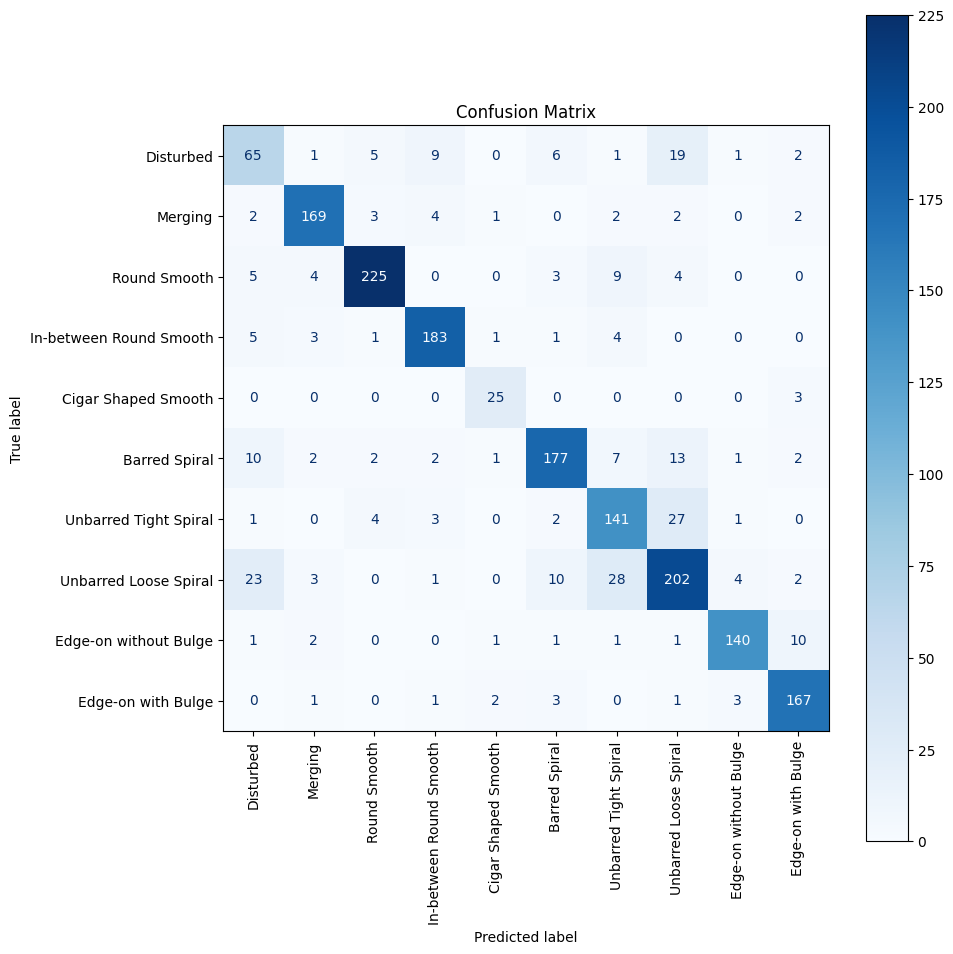

In [ ]:
true_test_labels = galaxy_dataset['test']['label']
test_metrics = evaluate_predictions(preds, true_test_labels, class_names)